# Assignment 2
#### Name: Jaimon Thyparambil Thomas
#### Student ID: 29566428

## Part C. Self-Taught Learning
#### In this part, you implement self-taught learning for Neural Network using the Autoencoder that provided in Activity 5.2 and a 3-layer NN (from Activity 5.1 or H2O package)
### Question 3 [Self Taught Neural Network Learning, 30 Marks]
#### I. Load Task2C_labeled.csv, Task2C_unlabeled.csv and Task2C_test.csv data sets and required libraries (e.g., H2O). Note that we are going to use Task2C_labeled.csv and Task2C_unlabeled.csv for training the autoencoder. We are going to use Task2C_labeled.csv for training the classifier. Finally, we evaluate the trained classifier on the test Task2C_test.csv.

Loading Libraries

In [1]:
options(warn=-1)
library(h2o)


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------


Attaching package: 'h2o'

The following objects are masked from 'package:stats':

    cor, sd, var

The following objects are masked from 'package:base':

    %*%, %in%, &&, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc



In [2]:
library(reshape2) # used for melt function
library(ggplot2)        # used for plotting graphs

In [3]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html

error.rate <- function(Y1, T1){
  if (nrow(Y1)!=nrow(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/nrow(T1))
}

##########################

Loading Data

In [4]:
options(warn=-1)
#If there is a proxy: proxy.old <- Sys.getenv('http_proxy'); Sys.setenv('http_proxy'='');
localH2O =  h2o.init(nthreads = -1, port = 54321, max_mem_size = '6G', startH2O = TRUE)


# Students: Use the "absolute" path to the datasets on your machine (important)

labeled.frame <- h2o.importFile(path = 'C:/Users/Jaimon\ TT/FIT5201\ -\ Machine\ Learning/Assignments/Assignment2/Task2C_labeled.csv' ,sep=',') 
unlabeled.frame <- h2o.importFile(path = 'C:/Users/Jaimon\ TT/FIT5201\ -\ Machine\ Learning/Assignments/Assignment2/Task2C_unlabeled.csv' ,sep=',') 
test.frame <- h2o.importFile(path = 'C:/Users/Jaimon\ TT/FIT5201\ -\ Machine\ Learning/Assignments/Assignment2/Task2C_test.csv' ,sep=',') 

labeled.frame[,1] <- as.factor(labeled.frame$label)
unlabeled.frame[,1] <- NA
train.frame <- h2o.rbind(labeled.frame[,-1], unlabeled.frame[,-1])
test.frame[,1] <- as.factor(test.frame$label)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\JAIMON~1\AppData\Local\Temp\RtmpwrB02c\file720403f25e6/h2o_Jaimon_TT_started_from_r.out
    C:\Users\JAIMON~1\AppData\Local\Temp\RtmpwrB02c\file7206bf2db/h2o_Jaimon_TT_started_from_r.err


Starting H2O JVM and connecting:  Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 518 milliseconds 
    H2O cluster timezone:       Australia/Sydney 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    2 months and 8 days  
    H2O cluster name:           H2O_started_from_R_Jaimon_TT_xpn911 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   5.33 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection prox

Variables used to store error

In [6]:
reconstruction.train.error <- matrix(NA, nrow=20, ncol=1)
classification.labeled.error <- matrix(NA, nrow=20, ncol=1)

reconstruction.test.error <- matrix(NA, nrow=20, ncol=1)
classification.test.error <- matrix(NA, nrow=20, ncol=1)

#### II. Train an autoencoder (similar to Activity 5.2) with only one hidden layer and change the number of its neurons to: 20, 40, 60, 80, …, 400 (i.e. from 20 to 400 with a step size of 20).

Saving autoencoder models for different values of neuron from 20,40,60...,400 into variable NN.model.single for further use 

In [7]:
set.seed(111)
firstEntry = TRUE
NN.model.single = 0
for (k in seq(20, 400, 20)){
  temp.single <- h2o.deeplearning(    
  x = 2:ncol(train.frame), # select all pixels + extra features
  training_frame = train.frame, # specify the frame (imported file)    
  hidden = c(k), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = TRUE, # is it an autoencoder? Yes!
  )
    if(firstEntry){
        NN.model.single = c(temp.single)
    }
    else{
        NN.model.single = c(NN.model.single,temp.single)
    }
    firstEntry = FALSE
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

#### III. For each model in Step II, calculate and record the reconstruction error which is simply the average (over all data points while the model is fixed) of Euclidian distances between the input and output of the autoencoder (you can simply use “h2o.anomaly()” function). Plot these values where the x-axis is the number of units in the middle layer and the y-axis is the reconstruction error. Then, save and attach the plot to your PDF report. Explain your findings based on the plot in your PDF report.

Calculating the reconstruction error for each model on both train and test data

In [8]:
set.seed(111)
train.len = nrow(train.frame)
test.len = nrow(test.frame[,-1])
for(i in 1:20){
    reconstruction.train.error[i] = sum(h2o.anomaly(NN.model.single[[i]], train.frame))/train.len
    reconstruction.test.error[i] = sum(h2o.anomaly(NN.model.single[[i]], test.frame[,-1]))/test.len
}

Converting reconstruction error into a structure which is easier to plot

In [9]:
recon.error.plot.data.frame =  data.frame(i=1:20,'units' = rep(0,20) ,'test'=rep(0,20), 'train'=rep(0,20))
for(i in 1:20){
    recon.error.plot.data.frame[i,'units'] = i*20
    recon.error.plot.data.frame[i,'train'] = reconstruction.train.error[i]
    recon.error.plot.data.frame[i,'test'] = reconstruction.test.error[i]
}
recon.error.plot.data.frame.m = melt(recon.error.plot.data.frame[,c('units','train','test')], id='units') # reshape for visualization
names(recon.error.plot.data.frame.m) <- c('units', 'type', 'reconstruction.error')

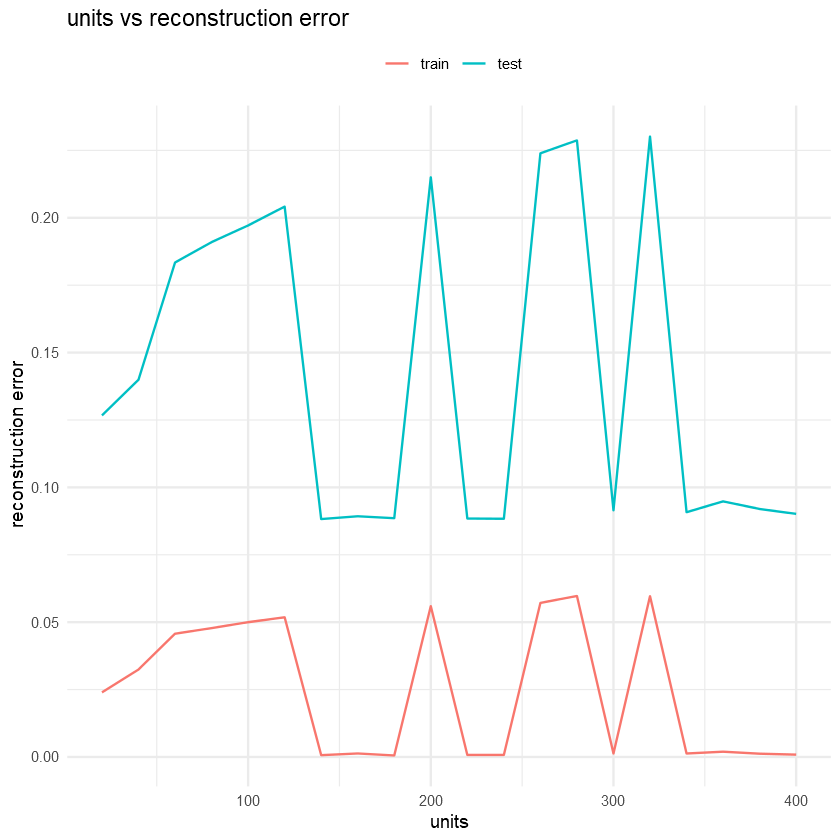

In [10]:
ggplot(data=recon.error.plot.data.frame.m, aes(x=units, y=reconstruction.error, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "units vs reconstruction error", y="reconstruction error",
           x = "units")

We can see that after a particular value of units both train and test reconstruction error is very less and almost constant

#### IV. Build the 3-layer NN from Activity 5.1 or “h2o.deeplearning” function (make sure you set “ autoencoder = FALSE”) to build a classification model using all the original attributes from the training set and change the number of its neurons to: 20, 40, 60, 80, .., 400 like Step II. For each model, calculate and record the test error.

Saving classification models for different values of neuron from 20,40,60...,400 into variable NN.3N.labeled.model for further use 

In [11]:
set.seed(111)
# build a neural network classifier based on the labeled training data
firstEntry = TRUE
NN.3N.labeled.model = 0
for (k in seq(20, 400, 20)){
  temp <- h2o.deeplearning(    
  x = 2:ncol(labeled.frame), # select all pixels + extra features
  y = 1,
  training_frame = labeled.frame, # specify the frame (imported file)    
  hidden = c(k), # number of layers and their units
  epochs = 50, # maximum number of epoches  
  activation = 'Tanh', # activation function 
  autoencoder = FALSE, # is it an autoencoder? Yes!
  l2 = 0.1
)
    if(firstEntry){
        NN.3N.labeled.model = c(temp)
    }
    else{
        NN.3N.labeled.model = c(NN.3N.labeled.model,temp)
    }
    firstEntry = FALSE
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

Predicting the values based on the models and calculating error for each of these models

In [12]:
set.seed(111)
for(i in 1:20){
    test.predict <- h2o.predict(NN.3N.labeled.model[[i]], test.frame)$predict
    classification.test.error[i] = error.rate(test.frame$label, test.predict)
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

Plotting the classification error for different values of neuron

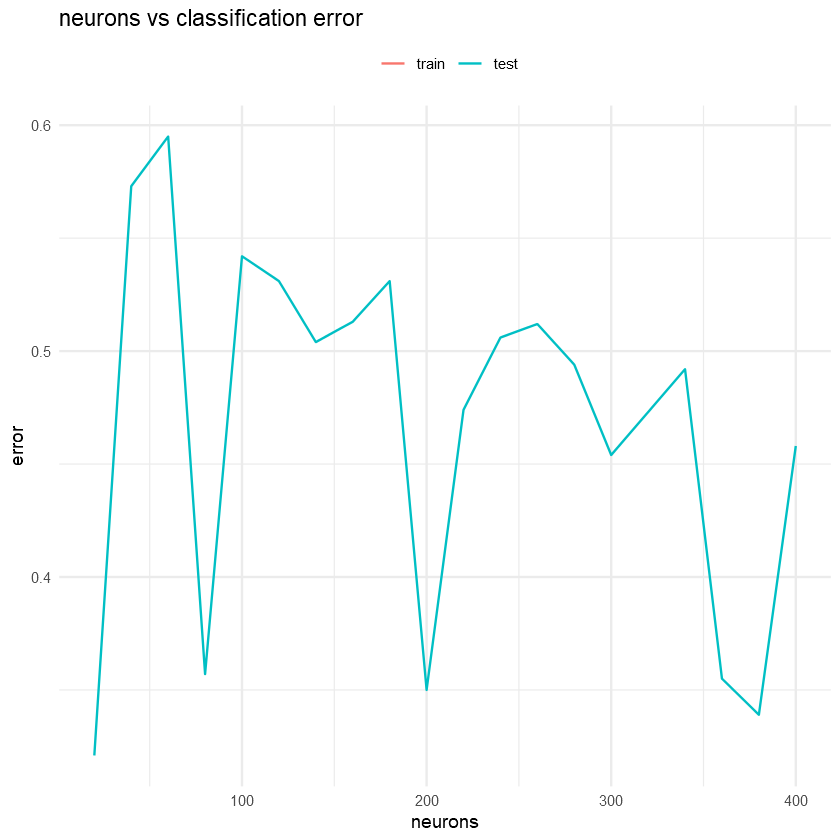

In [63]:
set.seed(111)
classification.plot.data.frame =  data.frame(i=1:20,'neurons' = rep(0,20) ,'test'=rep(0,20), 'train'=rep(0,20))
for(i in 1:20){
    recon.error.plot.data.frame[i,'neurons'] = i*20
    recon.error.plot.data.frame[i,'train'] = classification.labeled.error[i]
    recon.error.plot.data.frame[i,'test'] = classification.test.error[i]
}
recon.error.plot.data.frame.m = melt(recon.error.plot.data.frame[,c('neurons','train','test')], id='neurons') # reshape for visualization
names(recon.error.plot.data.frame.m) <- c('neurons', 'type', 'error')

ggplot(data=recon.error.plot.data.frame.m, aes(x=neurons, y=error, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "neurons vs classification error", y="error",
           x = "neurons")

#### V. Build augmented self-taught networks using the models learnt in Step II. For each model:
#### A. Add the output of the middle layer as extra features to the original feature set.

Extracting the features of the middle layer and saving it into a variable autoencoder.extra.features

In [14]:
set.seed(111)
autoencoder.extra.features = 0
firstEntry = TRUE
for (i in 1:20){
    temp = as.matrix(h2o.deepfeatures(NN.model.single[[i]], labeled.frame[,-1], layer=1))
    temp.h2o <- as.h2o(temp)
    temp.train.frame <- h2o.cbind(labeled.frame, temp.h2o)
    if(firstEntry){
        autoencoder.extra.features = c(temp.train.frame)
    }
    else{
        autoencoder.extra.features = c(autoencoder.extra.features,temp.train.frame)
    }
    firstEntry = FALSE
}

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

#### B. Train a 3-layer NN (similar to Step IV) using all features (original + extra). Then calculate and record the test error.

Calculating error in new model using features(original + extra)

In [29]:
set.seed(111)
# build a neural network classifier based on the labeled training data
firstEntry = TRUE
res.data.frame =  data.frame(i=1:20,'neurons' = seq(20, 400, 20))
for(i in 1:20){
    error <- matrix(NA, nrow=20, ncol=1)
    temp = 0
    j = 1
    for (k in seq(20, 400, 20)){
      temp <- h2o.deeplearning(    
      x = 2:ncol(autoencoder.extra.features[[i]]), # select all pixels + extra features
      y = 1,
      training_frame = autoencoder.extra.features[[i]], # specify the frame (imported file)    
      hidden = c(k), # number of layers and their units
      epochs = 50, # maximum number of epoches  
      activation = 'Tanh', # activation function 
      autoencoder = FALSE, # is it an autoencoder? Yes!
      l2 = 0.1
    )   
        test.predict <- h2o.predict(temp, test.frame)$predict
        error[j] = error.rate(test.frame$label, test.predict)
        j = j+1
    }
    temp.str = paste(c("model", i), collapse = " ")
    res.data.frame[temp.str] = error
}


  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |=====================================

#### VI. Plot the error rates for the 3-layer neural networks from Step IV and the augmented self-taught networks from Step V, while the x-axis is the number of hidden neurons and y-axis is the classification error. Save and attach the plot to your PDF report. In your pdf, explain how the performance of the 3-layer neural networks and the augmented self-taught network s is different and why they are different or why they are not different, based on the plot.
#### Hint: Since the dataset for this task is large and high-dimensional, running the whole experiments several times is very time consuming. Therefore, it is recommended to only use a small portion of your data when you develop or debug your code.
#### Hint: If you can combine Step II, IV and V (so learn each autoencoder only once), you may save a great portion of the execution time.
#### Hint: If you don’t see the expected behaviour in your plots, you may need to check that the data is clean, i.e. it doesn’t have NA entries, it’s normalised etc. Moreover, you may need to check that your implementation of the model and training/decoding algorithms is correct.


In [42]:
res.data.frame.m = melt(res.data.frame[,-1], id='neurons') # reshape for visualization
names(res.data.frame.m) <- c('neurons', 'model', 'error')
head(res.data.frame.m)

neurons,model,error
20,model 1,0.341
40,model 1,0.577
60,model 1,0.577
80,model 1,0.329
100,model 1,0.583
120,model 1,0.485


Plot of of STEP IV

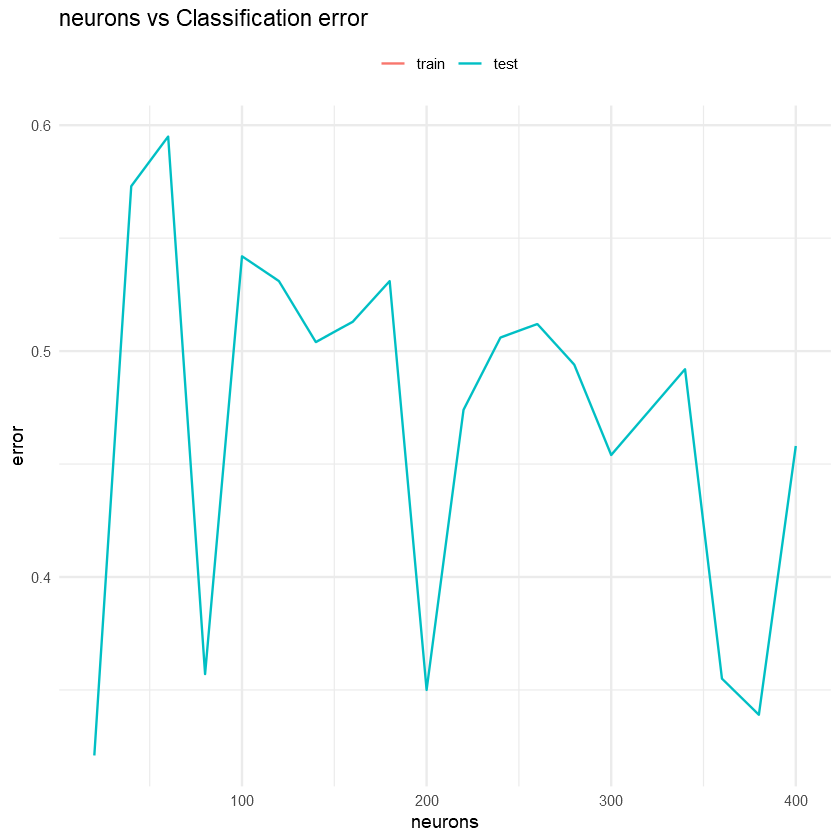

In [64]:
set.seed(111)
classification.plot.data.frame =  data.frame(i=1:20,'neurons' = rep(0,20) ,'test'=rep(0,20), 'train'=rep(0,20))
for(i in 1:20){
    recon.error.plot.data.frame[i,'neurons'] = i*20
    recon.error.plot.data.frame[i,'train'] = classification.labeled.error[i]
    recon.error.plot.data.frame[i,'test'] = classification.test.error[i]
}
recon.error.plot.data.frame.m = melt(recon.error.plot.data.frame[,c('neurons','train','test')], id='neurons') # reshape for visualization
names(recon.error.plot.data.frame.m) <- c('neurons', 'type', 'error')

ggplot(data=recon.error.plot.data.frame.m, aes(x=neurons, y=error, color=type)) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "neurons vs Classification error", y="error",
           x = "neurons")

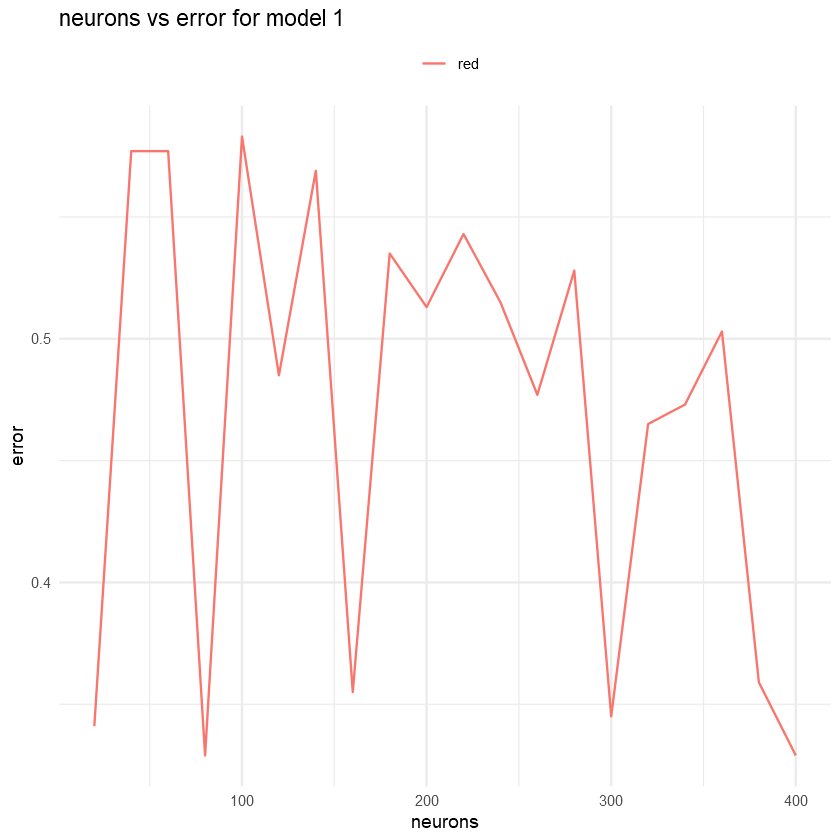

In [59]:
ggplot(data=res.data.frame[,-1], aes(x=neurons, y=res.data.frame[,"model 1"], color="red")) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "neurons vs error for model 1", y="error",
           x = "neurons")

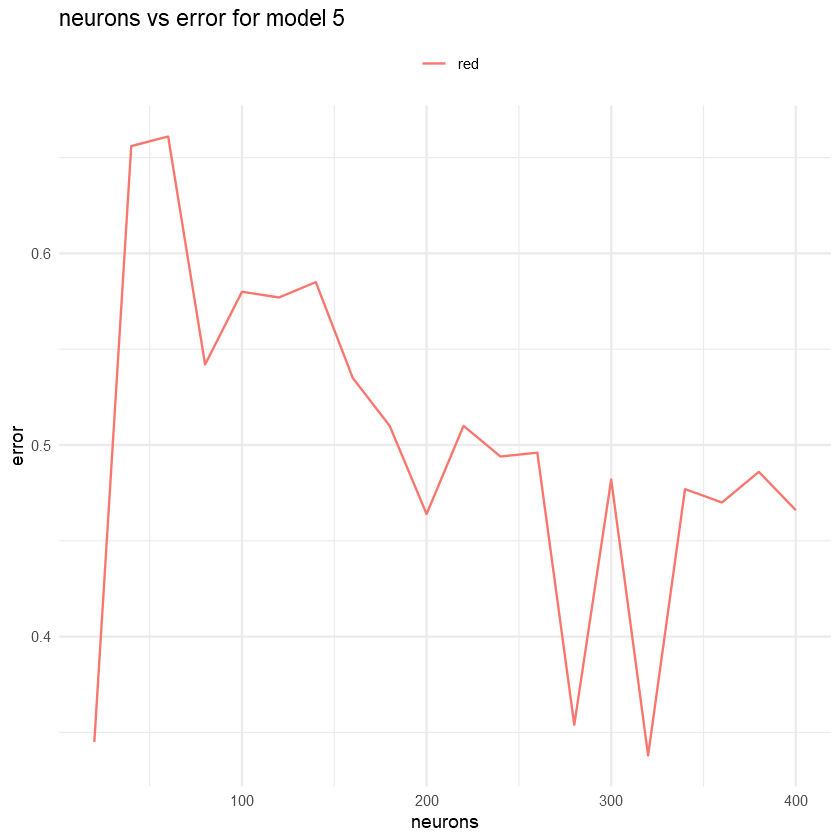

In [60]:
ggplot(data=res.data.frame[,-1], aes(x=neurons, y=res.data.frame[,"model 5"], color="red")) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "neurons vs error for model 5", y="error",
           x = "neurons")

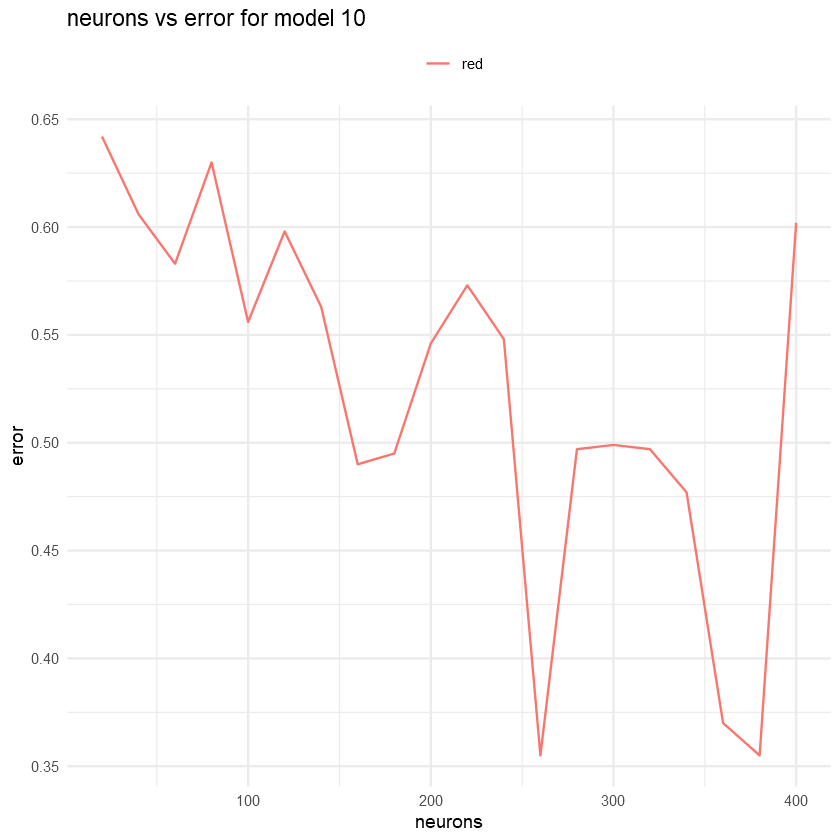

In [61]:
ggplot(data=res.data.frame[,-1], aes(x=neurons, y=res.data.frame[,"model 10"], color="red")) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "neurons vs error for model 10", y="error",
           x = "neurons")

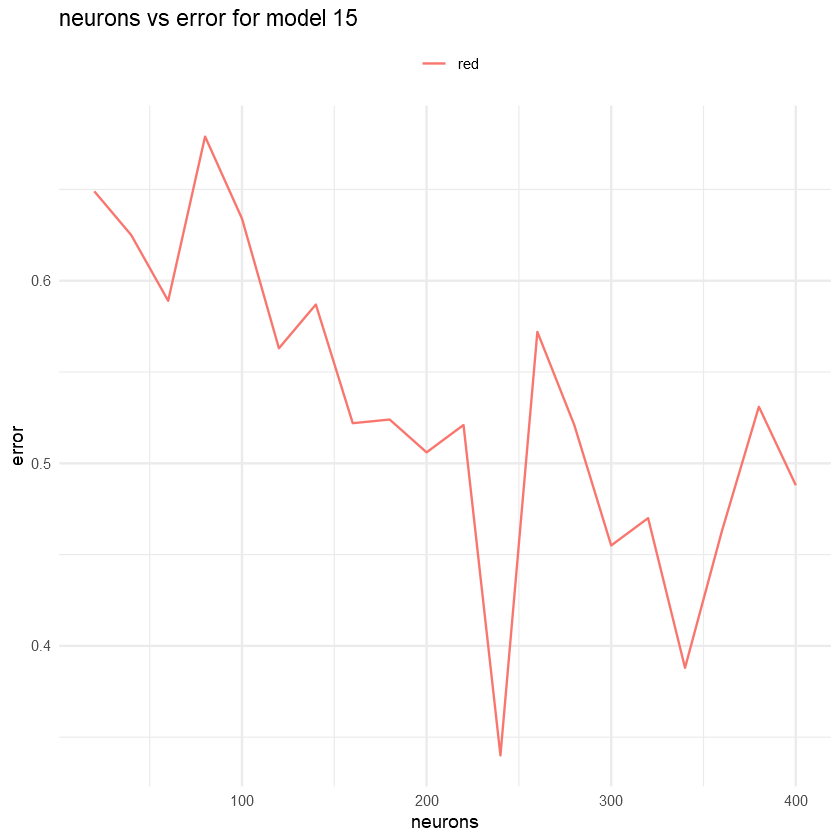

In [62]:
ggplot(data=res.data.frame[,-1], aes(x=neurons, y=res.data.frame[,"model 15"], color="red")) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "neurons vs error for model 15", y="error",
           x = "neurons")

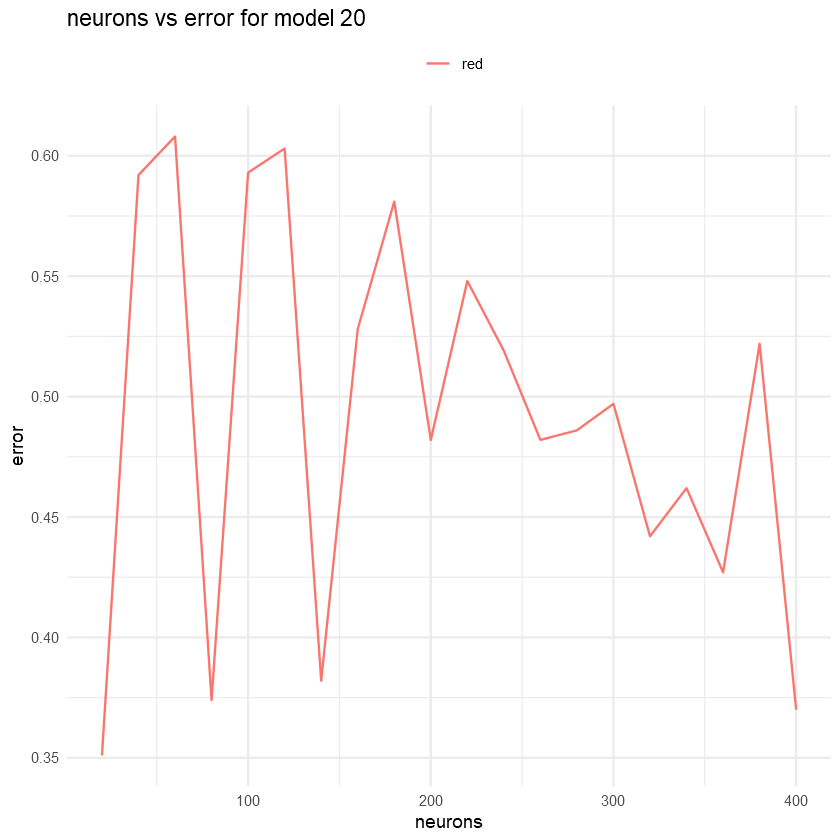

In [58]:
ggplot(data=res.data.frame[,-1], aes(x=neurons, y=res.data.frame[,"model 20"], color="red")) + geom_line() +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() + theme(legend.position="top") +
      labs( title= "neurons vs error for model 20", y="error",
           x = "neurons")

Here generally we can see that as the number of neurons are increasing the error is decreasing